# Chatbot Arena Routing
[Chatbot Arena Conversation Dataset](https://lmsys.org/blog/2023-07-20-dataset/]) is a dataset collected by LMSYS Org. It consists of 33K rows of battles between two LLMs as well as a judge's decision on which model performs better. We are going to use magic-carpet to spin up a few model routers to try and tackle this task.

In [2]:
import os 
from dotenv import load_dotenv
from collections import defaultdict
import json, math
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
from typing import Callable
from datasets import load_dataset
import faiss
from openai import OpenAI
from magic_carpet.routers.router import NamedRouter

load_dotenv()

True

In [34]:
DATASET_NAME = "lmsys/chatbot_arena_conversations"
if not os.path.exists("dataset.json"):
    print("Loading dataset ...")
    dataset = load_dataset(DATASET_NAME)
    dataset["train"].to_json("dataset.json")
df = pd.read_json("dataset.json", lines=True).sort_values(ascending=True, by=["tstamp"])
df.shape

(33000, 13)

In [4]:
# model_names = list(set(df.model_a.unique().tolist() + df.model_b.unique().tolist()))
model_names = ['gpt-4', 'gpt-3.5-turbo', 'claude-v1', 'palm-2', 'vicuna-13b', 'koala-13b', 'llama-13b', 'alpaca-13b']
df = df[df.language == "English"]
df = df[df.model_a.isin(model_names) & df.model_b.isin(model_names)]
df.shape

(7284, 13)

In [5]:
def no_ties(df):
    return df[df.winner.str.contains("tie") == False]
df.winner.value_counts(), no_ties(df).winner.value_counts()

(winner
 model_a          2679
 model_b          2598
 tie              1100
 tie (bothbad)     907
 Name: count, dtype: int64,
 winner
 model_a    2679
 model_b    2598
 Name: count, dtype: int64)

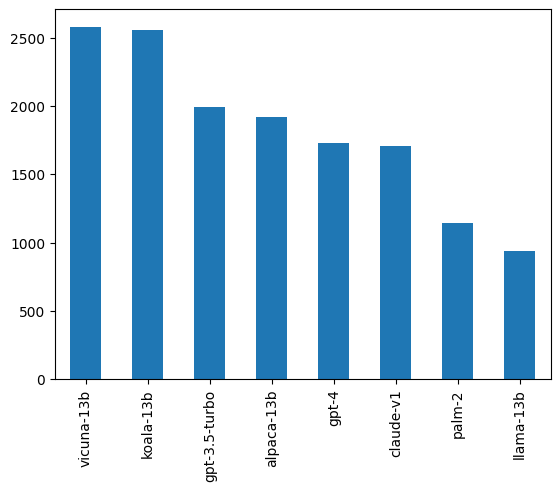

In [6]:
model_a_counts = df.model_a.value_counts()
model_b_counts = df.model_b.value_counts()
_ = (model_a_counts + model_b_counts).sort_values(ascending=False).plot.bar()

In [7]:
# randomly shuffle rows of df 
df = df.sample(frac=1, random_state=100)

try:
    with open("shuffled_indices.json", "r") as f:
        df_random_shuffle = json.load(f)
    assert df_random_shuffle == df.index[:100].tolist()
except:
    print("Saving shuffled indices ...")
    with open("shuffled_indices.json", "w") as f:
        json.dump(df.index[:100].tolist(), f)


df = df.reset_index(drop=True)
# test_size = int(len(df)*0.3)
test_size = 150
train_df, test_df = df.iloc[:-test_size].copy(), df.iloc[-test_size:].copy()
train_df.shape, test_df.shape

Saving shuffled indices ...


((7134, 13), (150, 13))

In [8]:
def get_input(messages):
    for msg in messages:
        if msg['role'] == 'user':
            return msg['content']
        
def get_response(messages):
    for msg in messages:
        if msg['role'] == 'assistant':
            return msg['content']

models = [
    {
        "name": model_name, 
        "description": "Extract the response from the conversation",
        "function": get_response,
    } for model_name in model_names
]
models[0], get_input(messages=train_df.conversation_a[0]), models[0]["function"](messages=train_df.conversation_a[0])

({'name': 'gpt-4',
  'description': 'Extract the response from the conversation',
  'function': <function __main__.get_response(messages)>},
 'What is a good mesage to put in an initial pull request on github',
 "When submitting an initial pull request on Github, it's important to be clear and concise about what you're trying to do, and to include any relevant information and context. Here are a few tips for crafting a good pull request message:\n\n1.   Introduce yourself and explain what you're doing: Start by introducing yourself and providing some context about why you're submitting a pull request. This will help the maintainers of the repository understand your motives and make it easier for them to evaluate your request.\n2.   Describe the changes you're proposing: Make sure to describe the changes you're proposing in detail, including any relevant context or background information. It's also a good idea to include any reasons why these changes are important or beneficial.\n3.   P

In [9]:
tqdm.pandas()
def router_score(df, router, row_keys, allow_ties=False, verbose=False):
    df = no_ties(df) if not allow_ties else df
    def row_score(row):
        metadata = router(**dict(row[row_keys]), metadata_only=True)
        # print(f"MODELS: {row.model_a}, {row.model_b}\n\nREASONING:\n\n{metadata.get('llm_response')}\n\nWINNER: {row.winner}")
        return int(metadata["winner"] == row.winner)
    if verbose:
        return df.progress_apply(row_score, axis=1).mean()
    return df.apply(row_score, axis=1).mean()

## Perfect Arena Router

In [10]:
WINNER_OPTIONS = df.winner.unique().tolist()

class PerfectArenaRouter(NamedRouter):
    def route(self, model_a, model_b, conversation_a, conversation_b, winner='model_a', winner_options=WINNER_OPTIONS):
        choices = {
            'model_a': (model_a, conversation_a),
            'model_b': (model_b, conversation_b),
        }
        if winner not in winner_options:
            raise ValueError(f"Winner must be one of {winner_options}")
        if winner.startswith("tie"):
            winner = "model_a"
        model_name, messages = choices[winner]
        return self.models[model_name], {"winner": winner, "exec_kwargs": {"messages": messages}}
    
perfect_router = PerfectArenaRouter(models)
str(perfect_router)

'PerfectArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])'

In [11]:
print("Example of what router info looks like ...")
print(perfect_router.info())

Example of what router info looks like ...
NAME: PerfectArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])
DESCRIPTION: Router for 8 models listed below
[
	(0) gpt-4: Extract the response from the conversation,
	(1) gpt-3.5-turbo: Extract the response from the conversation,
	(2) claude-v1: Extract the response from the conversation,
	(3) palm-2: Extract the response from the conversation,
	(4) vicuna-13b: Extract the response from the conversation,
	(5) koala-13b: Extract the response from the conversation,
	(6) llama-13b: Extract the response from the conversation,
	(7) alpaca-13b: Extract the response from the conversation
]


In [12]:
score = router_score(test_df, perfect_router, ["model_a", "model_b", "conversation_a", "conversation_b", "winner"], verbose=True)
f"Perfect Router Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 1967.59it/s]


'Perfect Router Accuracy: 1.0000'

## Ratings-based Arena Router

In [13]:
def compute_pairwise_win_fraction(battles):
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_a"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_b"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles,
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) /
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig = px.imshow(row_beats_col, color_continuous_scale='RdBu',
                    text_auto=".2f", title=title)
    fig.update_layout(xaxis_title=" Model B: Loser",
                  yaxis_title="Model A: Winner",
                  xaxis_side="top", height=600, width=600,
                  title_y=0.07, title_x=0.5)
    fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Fraction of A Wins: %{z}<extra></extra>")

    return fig
fig = visualize_pairwise_win_fraction(no_ties(train_df),
      title = "Fraction of Model A Wins for All Non-tied A vs. B Battles")
fig

In [14]:
row_beats_col_freq = compute_pairwise_win_fraction(no_ties(train_df))
fig = px.bar(row_beats_col_freq.mean(axis=1).sort_values(ascending=False),
             title="Average Win Rate Against All Other Models (Assuming Uniform Sampling and No Ties)",
             text_auto=".2f")
fig.update_layout(yaxis_title="Average Win Rate", xaxis_title="Model",
                  showlegend=False)
naive_model_ratings = dict(row_beats_col_freq.mean(axis=1).sort_values(ascending=False))
fig


In [15]:
def compute_elo(battles, K=4, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, winner in battles[['model_a', 'model_b', 'winner']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if winner == "model_a":
            sa = 1
        elif winner == "model_b":
            sa = 0
        elif winner == "tie" or winner == "tie (bothbad)":
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {winner}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    return rating

def pretty_print_elo_ratings(ratings):
    df = pd.DataFrame([
        [n, ratings[n]] for n in ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

elo_model_ratings = compute_elo(train_df)
pretty_print_elo_ratings(elo_model_ratings)

,Model,Elo rating
1,gpt-4,1181
2,claude-v1,1149
3,gpt-3.5-turbo,1078
4,palm-2,1009
5,vicuna-13b,1003
6,koala-13b,991
7,alpaca-13b,858
8,llama-13b,731


In [16]:
set([model["name"] for model in models]) == set(naive_model_ratings.keys()), set([model["name"] for model in models]) == set(elo_model_ratings.keys())

(True, True)

In [17]:
class RatingsArenaRouter(NamedRouter):
    def __init__(self, *args, model_ratings: dict, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_ratings = model_ratings

    def route(self, model_a, model_b, conversation_a, conversation_b):
        if self.model_ratings[model_a] > self.model_ratings[model_b]:
            winner = "model_a"
        else:
            winner = "model_b"

        model_name, messages = {
            'model_a': (model_a, conversation_a),
            'model_b': (model_b, conversation_b),
        }[winner]

        return self.models[model_name], \
            {
                "winner": winner, 
                "scores": [{"name": name, "score": self.model_ratings[name]} for name in [model_a, model_b]], 
                "exec_kwargs": {"messages": messages}
            }


In [18]:
naive_ratings_router = RatingsArenaRouter(models, model_ratings=naive_model_ratings)
elo_ratings_router = RatingsArenaRouter(models, model_ratings=elo_model_ratings)
str(naive_ratings_router), str(elo_ratings_router)

('RatingsArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])',
 'RatingsArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])')

In [19]:
score = router_score(test_df, naive_ratings_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)
f"Naive Ranking Router Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 2472.00it/s]


'Naive Ranking Router Accuracy: 0.7143'

In [20]:
score = router_score(test_df, elo_ratings_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)
f"Elo Ranking Router Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 2303.17it/s]


'Elo Ranking Router Accuracy: 0.7143'

## Nearest Neighbor Arena Router

In [21]:
def openai_embedder(inputs, model="text-embedding-ada-002", api_key=os.environ["OPENAI_API_KEY"], batch_size=2048, **kwargs):
    client = OpenAI(
        # This is the default and can be omitted
        api_key=api_key,
    )
    embedding_list = []
    for i in range(math.ceil(len(inputs)/batch_size)):
        embedding_list.append([d.embedding for d in client.embeddings.create(input=inputs[i*batch_size:(i+1)*batch_size], model=model).data])
    # convert df to list of strings assuming that df is just a series of Strings 
    return np.concatenate(embedding_list).astype(np.float32)

test_embeddings = openai_embedder(["Hello", "World"])

test_embeddings.shape, np.linalg.norm(test_embeddings, axis=1)

((2, 1536), array([0.99999994, 1.        ], dtype=float32))

In [24]:
class NNArenaRouter(NamedRouter):
    def __init__(self, *args, embedder: Callable = openai_embedder, d: int = 1536, k: int = 15, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedder = embedder
        self.d = d
        self.k = k
        self.indices = {name: faiss.IndexFlatIP(d) for name in self.models}

    def train(self, train_df, verbose: bool = True, **kwargs):
        if not (train_df['conversation_a'].apply(get_input) == train_df['conversation_b'].apply(get_input)).all():
            raise ValueError("All conversation inputs must be the same")
        train_df['input'] = train_df['conversation_a'].apply(get_input)
        self.train_data = {name: pd.concat([train_df[train_df.model_a == name], train_df[train_df.model_b == name]]).reset_index(drop=True) for name in self.models}
        data_iterator = tqdm(self.train_data.items(), desc="Creating indices") if verbose else self.train_data.items()
        for name, df in data_iterator:
            vectors = self.embedder(df.input.values.tolist(), **kwargs)
            self.indices[name].add(vectors)            
    
    def score_nn_df(self, model_name, nn_df):
        def score_row(row):
            if (row.winner.startswith("tie")):
                return 0
            if (row.model_a == model_name) and (row.winner == "model_a"):
                return 1
            elif (row.model_b == model_name) and (row.winner == "model_b"):
                return 1
            else:
                return -1
        return nn_df.apply(score_row, axis=1).sum()

    def route(self, model_a, model_b, conversation_a, conversation_b, **kwargs):
        input = get_input(conversation_a)
        if not (input == get_input(conversation_b)):
            raise ValueError("Conversation inputs must be the same")
        input_embedding = self.embedder([input], **kwargs)
        _, nn_a_indices = self.indices[model_a].search(input_embedding, self.k)
        _, nn_b_indices = self.indices[model_b].search(input_embedding, self.k)

        nn_a_df = self.train_data[model_a].iloc[nn_a_indices[0]]
        nn_b_df = self.train_data[model_b].iloc[nn_b_indices[0]]

        model_a_score = self.score_nn_df(model_a, nn_a_df)
        model_b_score = self.score_nn_df(model_b, nn_b_df)
    
        if model_a_score > model_b_score:
            winner = "model_a"
        else:
            winner = "model_b"

        model_name, messages = {
            'model_a': (model_a, conversation_a),
            'model_b': (model_b, conversation_b),
        }[winner]

        if model_a_score > model_b_score:
            true_winner = "model_a"
        elif model_a_score < model_b_score:
            true_winner = "model_b"
        elif model_a_score >= 0:
            true_winner = "tie (bothbad)"
        else:
            true_winner = "tie"

        return self.models[model_name], \
            {
                "winner": true_winner, 
                "scores": [{"name": name, "score": score} for name, score in zip([model_a, model_b], [model_a_score, model_b_score])], 
                "nn_indices": [{"name": name, "indices": indices} for name, indices in zip([model_a, model_b], [nn_a_indices, nn_b_indices])],
                "exec_kwargs": {"messages": messages}
            }

nn_router = NNArenaRouter(models)
# nn_router.train(train_df)  # commented out to save time
str(nn_router)

'NNArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])'

In [23]:
# score = router_score(test_df, nn_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)  # commented out to save time
score = 0.0
f"NN Router Accuracy: {score:.4f}"

'NN Router Accuracy: 0.0000'

In [25]:
def random_embedder(inputs, size=1536):
    unnormalized = np.random.normal(size=(len(inputs), size))
    return unnormalized / np.linalg.norm(unnormalized, axis=1, keepdims=True)


test_embeddings = random_embedder(["Hello", "World"])

test_embeddings.shape, np.linalg.norm(test_embeddings, axis=1)

((2, 1536), array([1., 1.]))

In [26]:
random_nn_router = NNArenaRouter(models, embedder=random_embedder)
random_nn_router.train(train_df)
str(random_nn_router)

Creating indices: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


'NNArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])'

In [27]:
score = router_score(test_df, random_nn_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)
f"Random NN Router (dim=1536) Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 234.90it/s]


'Random NN Router (dim=1536) Accuracy: 0.6807'

In [28]:
def length_embedder(inputs, max_words=500):
    num_words = np.array([len(input.split()) for input in inputs])
    num_words = np.clip(num_words, 1, max_words)
    thetas = np.log10(num_words) / np.log10(max_words)
    return np.stack([np.cos(thetas), np.sin(thetas)], axis=1)

test_embeddings = length_embedder(["Hello", "World", "How are you doing?"])

test_embeddings.shape, np.linalg.norm(test_embeddings, axis=1)


((3, 2), array([1., 1., 1.]))

In [29]:
length_nn_router = NNArenaRouter(models, embedder=length_embedder, d=2)
length_nn_router.train(train_df)
str(length_nn_router)

Creating indices: 100%|██████████| 8/8 [00:00<00:00, 170.79it/s]


'NNArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])'

In [30]:
score = router_score(test_df, length_nn_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)
f"Length NN Router Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 410.95it/s]


'Length NN Router Accuracy: 0.6723'

In [31]:
random_nn_router = NNArenaRouter(models, embedder=lambda input: random_embedder(input, size=2), d=2)
random_nn_router.train(train_df)
str(random_nn_router)

Creating indices: 100%|██████████| 8/8 [00:00<00:00, 2368.33it/s]


'NNArenaRouter([gpt-4, gpt-3.5-turbo, claude-v1, palm-2, vicuna-13b, koala-13b, llama-13b, alpaca-13b])'

In [32]:
score = router_score(test_df, random_nn_router, ["model_a", "model_b", "conversation_a", "conversation_b"], verbose=True)
f"Random NN Router (dim=2) Accuracy: {score:.4f}"

100%|██████████| 119/119 [00:00<00:00, 323.02it/s]


'Random NN Router (dim=2) Accuracy: 0.6387'